In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive 
import imutils

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [5]:
def crop_image(image, plot=False):
    
    #convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    #apply binary threshhold
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    #apply erosion
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    #dilate images
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    #find shapes or the contour of images
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #grab contours
    contours = imutils.grab_contours(contours)

    #find biggest contour
    c = max(contours, key=cv2.contourArea)

    #extract contour positions
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #generate new image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    #plot
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


In [6]:
def rotate(image, angle):
  height, width = image.shape[:2]
  center = (width/2, height/2)
  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))
  return rotated_image

In [7]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X1 = []
y1  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','meningioma_tumor')
for file in tqdm(os.listdir(trainPath)):
    image = cv2.imread(os.path.join(trainPath, file))
    image = crop_image(image, plot=False)
    image = cv2.resize(image, (image_size, image_size))
    X1.append(image)
    y1.append('meningioma_tumor')
    
X1 = np.array(X1)

100%|██████████| 708/708 [00:17<00:00, 40.90it/s]


In [8]:
X1.shape

(708, 150, 150, 3)

In [9]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X2 = []
y2  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','glioma_tumor')
for file in tqdm(os.listdir(trainPath)):
    image = cv2.imread(os.path.join(trainPath, file))
    image = crop_image(image, plot=False)
    image = cv2.resize(image, (image_size, image_size))
    X2.append(image)
    y2.append('glioma_tumor')
    
X2 = np.array(X2)

100%|██████████| 1426/1426 [00:22<00:00, 62.79it/s]


In [10]:
X2.shape

(1426, 150, 150, 3)

In [11]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X3 = []
y3  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','pituitary_tumor')
for file in tqdm(os.listdir(trainPath)):
    image = cv2.imread(os.path.join(trainPath, file))
    image = crop_image(image, plot=False)
    image = cv2.resize(image, (image_size, image_size))
    X3.append(image)
    y3.append('pituitary_tumor')
    
X3 = np.array(X3)

100%|██████████| 930/930 [00:14<00:00, 62.83it/s]


In [12]:
X3.shape

(930, 150, 150, 3)

In [13]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X4 = []
y4  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','no_tumor')
for file in tqdm(os.listdir(trainPath)):
    image = cv2.imread(os.path.join(trainPath, file))
    image = crop_image(image, plot=False)
    image = cv2.resize(image, (image_size, image_size))
    X4.append(image)
    y4.append('no_tumor')
    
X4 = np.array(X4)

100%|██████████| 501/501 [00:05<00:00, 88.88it/s] 


In [14]:
X4.shape

(501, 150, 150, 3)

In [15]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X11 = []
y11  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','meningioma_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, 5)
  X11.append(image)
  y11.append('meningioma_tumor')
    
X11 = np.array(X11)

100%|██████████| 708/708 [00:09<00:00, 72.98it/s]


In [16]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X12 = []
y12  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','meningioma_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, -5)
  X12.append(image)
  y12.append('meningioma_tumor')
    
X12 = np.array(X12)

100%|██████████| 708/708 [00:09<00:00, 72.18it/s]


In [17]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X13 = []
y13  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','meningioma_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, 6)
  X13.append(image)
  y13.append('meningioma_tumor')
    
X13 = np.array(X13)

100%|██████████| 708/708 [00:09<00:00, 73.05it/s]


In [18]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X21 = []
y21  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','glioma_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, 5)
  X21.append(image)
  y21.append('glioma_tumor')
    
X21 = np.array(X21)

100%|██████████| 1426/1426 [00:19<00:00, 71.86it/s]


In [19]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X31 = []
y31  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','pituitary_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, 5)
  X31.append(image)
  y31.append('pituitary_tumor')
    
X31 = np.array(X31)

100%|██████████| 930/930 [00:13<00:00, 69.29it/s]


In [20]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X32 = []
y32  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','pituitary_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, -5)
  X32.append(image)
  y32.append('pituitary_tumor')
    
X32 = np.array(X32)

100%|██████████| 930/930 [00:12<00:00, 71.91it/s]


In [21]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X41 = []
y41  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','no_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, 5)
  X41.append(image)
  y41.append('no_tumor')
    
X41 = np.array(X41)

100%|██████████| 501/501 [00:04<00:00, 103.62it/s]


In [22]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X42 = []
y42  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','no_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, -5)
  X42.append(image)
  y42.append('no_tumor')
    
X42 = np.array(X42)

100%|██████████| 501/501 [00:04<00:00, 101.89it/s]


In [23]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X43 = []
y43  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','no_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, 6)
  X43.append(image)
  y43.append('no_tumor')
    
X43 = np.array(X43)

100%|██████████| 501/501 [00:04<00:00, 103.72it/s]


In [24]:
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor','no_tumor']
X44 = []
y44  = []
image_size=150
trainPath = os.path.join('/content/drive/MyDrive/brain-tumor/','no_tumor')
for file in tqdm(os.listdir(trainPath)):
  image = cv2.imread(os.path.join(trainPath, file))
  image = crop_image(image, plot=False)
  image = cv2.resize(image, (image_size, image_size))
  image = rotate(image, -6)
  X44.append(image)
  y44.append('no_tumor')
    
X44 = np.array(X44)

100%|██████████| 501/501 [00:04<00:00, 104.55it/s]


In [25]:
X_meningioma = np.concatenate((X1, X11, X12, X13), axis=0)
X_meningioma.shape

(2832, 150, 150, 3)

In [26]:
X_pituitary = np.concatenate((X3, X31, X32), axis=0)
X_pituitary.shape

(2790, 150, 150, 3)

In [27]:
X_glioma = np.concatenate((X2, X21), axis=0)
X_glioma.shape

(2852, 150, 150, 3)

In [28]:
X_notumor = np.concatenate((X4, X41, X42, X43, X44), axis=0)
X_notumor.shape

(2505, 150, 150, 3)

In [29]:
y_meningioma = np.concatenate((y1, y11, y12, y13), axis=0)
y_meningioma.shape

(2832,)

In [30]:
y_pituitary = np.concatenate((y3, y31, y32), axis=0)
y_pituitary.shape

(2790,)

In [31]:
y_glioma = np.concatenate((y2, y21), axis=0)
y_glioma.shape

(2852,)

In [32]:
y_notumor = np.concatenate((y4, y41, y42, y43, y44), axis=0)
y_notumor.shape

(2505,)

In [33]:
X_train = np.concatenate((X_meningioma, X_glioma, X_pituitary, X_notumor), axis=0)
y_train = np.concatenate((y_meningioma, y_glioma, y_pituitary, y_notumor), axis=0)

In [34]:
X_train.shape

(10979, 150, 150, 3)

In [35]:
y_train.shape

(10979,)

In [36]:
X_train, y_train = shuffle(X_train, y_train, random_state=28)

In [37]:
#base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

## Transfer Learning with EfficientNetB3


## Define Callbacks

In [38]:
y_train_ = []
for i in y_train:
    y_train_.append(labels.index(i))
y_train = y_train_

y_train = tf.keras.utils.to_categorical(y_train)

In [39]:
X_train, X_dum, y_train, y_dum = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

In [40]:
X_test, X_val, y_test, y_val = train_test_split(X_dum, y_dum, test_size=0.5)

In [41]:
#y_test_ = []
#for i in y_test:
#    y_test_.append(labels.index(i))
#y_test = y_test_

#y_test = tf.keras.utils.to_categorical(y_test)

## Data Augmentation

In [42]:
datagen = ImageDataGenerator()

datagen.fit(X_train)

## Train Model

In [43]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [44]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

In [46]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("brain_tumor_classification.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [47]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                              validation_data=(X_val, y_val), 
                              epochs=30, 
                              verbose=1,
                            callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.7872
Epoch 1: val_accuracy improved from -inf to 0.76412, saving model to brain_tumor_classification.h5
275/275 [==============================] - 163s 485ms/step - loss: 0.5346 - accuracy: 0.7872 - val_loss: 0.5425 - val_accuracy: 0.7641 - lr: 0.0010
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8773
Epoch 2: val_accuracy improved from 0.76412 to 0.84335, saving model to brain_tumor_classification.h5
275/275 [==============================] - 128s 465ms/step - loss: 0.3241 - accuracy: 0.8773 - val_loss: 0.5290 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9202
Epoch 3: val_accuracy improved from 0.84335 to 0.87796, saving model to brain_tumor_classification.h5
275/275 [==============================] - 130s 472ms/step - loss: 0.2239 - accuracy: 0.9202 - val_loss: 0.3134 -

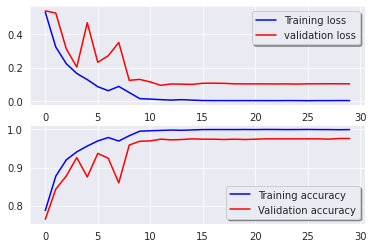

In [48]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [49]:
new_model = tf.keras.models.load_model('./brain_tumor_classification.h5')

In [50]:
pred = new_model.predict(X_val)
pred = np.argmax(pred,axis=1)
y_val_new = np.argmax(y_val,axis=1)
print("Accuracy on Valid set: {:.2f}%".format(np.sum(pred==y_val_new)/len(y_val_new)*100))

Accuracy on Valid set: 97.63%


In [51]:
train_pred = new_model.predict(X_train)
train_pred = np.argmax(train_pred,axis=1)
y_train_ = np.argmax(y_train,axis=1)
print("Accuracy on Train set: {:.2f}%".format(np.sum(train_pred==y_train_)/len(y_train_)*100))

Accuracy on Train set: 100.00%


In [52]:
test_pred = new_model.predict(X_test)
test_pred = np.argmax(test_pred,axis=1)
y_test_ = np.argmax(y_test,axis=1)
print("Accuracy on Train set: {:.2f}%".format(np.sum(test_pred==y_test_)/len(y_test_)*100))

Accuracy on Train set: 97.81%


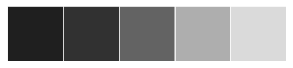

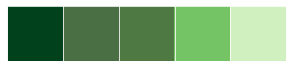

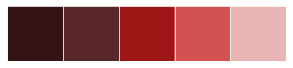

In [53]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

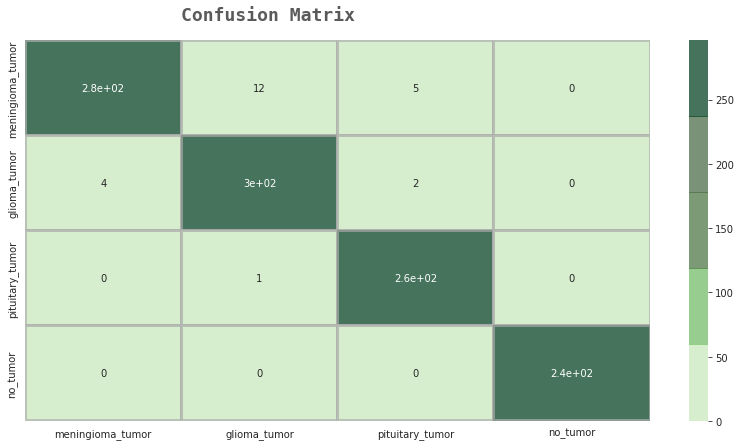

In [54]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_, test_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [55]:
print(classification_report(y_test_, test_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       297
           1       0.96      0.98      0.97       302
           2       0.97      1.00      0.98       261
           3       1.00      1.00      1.00       238

    accuracy                           0.98      1098
   macro avg       0.98      0.98      0.98      1098
weighted avg       0.98      0.98      0.98      1098



In [56]:
save_id=str ( 'EfficientNetB2_1'+ '.h5')
save_dir='/content/drive/My Drive/brain-tumor'
save_loc=os.path.join(save_dir, save_id)
new_model.save(save_loc)